In [1]:
import numpy as np
import pandas as pd
import seaborn  as sns
import matplotlib.pyplot as plt
np.random.seed(sum(map(ord, "aesthetics")))
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.preprocessing import scale
import scipy as sc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold


def parse_response(str_id):
    if str_id.split('_')[1] == 'resp':
        return 1
    return 0
   
    
def preprocess_dataset(dataset):
    gen_names = dataset["SYMBOL"].as_matrix()
    responses = np.zeros(dataset.shape[1]-1, dtype=np.int)
    target_ids = dataset.columns[1:].values
    feature_matrix = np.zeros((dataset.shape[1]-1, dataset.shape[0]), dtype=np.float)
    for idx, target_id in enumerate(target_ids):
        feature_matrix[idx, :] = dataset[target_id].values
        responses[idx] = parse_response(target_id)
    return feature_matrix, responses, target_ids, gen_names


def get_gen_hists(xpression, cl_masks, bins=10):
    xpr_range = (xpression.min(), xpression.max())
    hists = []
    for mask in cl_masks:
        hist, _ = np.histogram(xpression[mask], bins=bins, range=xpr_range)
        hists.append(hist)
    return hists


def get_pdf_sim(p, q):
    return -q.dot(np.log2(p)) - p.dot(np.log2(q))
    # return sc.stats.entropy(p, q)

    
def xpressions_to_order_matrix(xpressions):
    orders_num = np.arange(xpressions.shape[1], dtype=np.int32)
    order_matrix = np.zeros_like(xpressions, dtype=np.int32)
    for row in range(xpressions.shape[0]):
        ordered_ids = np.array([ind 
                          for ind, xpr in sorted([(ind, xpr) 
                                                   for ind, xpr in enumerate(xpressions[row,:])], key=lambda p: p[1])])
        order = np.zeros_like(ordered_ids, dtype=np.int32)
        order[ordered_ids] = np.arange(xpressions.shape[1])
        order_matrix[row, :] = order
    return order_matrix
    
    
def get_relation_matrix(order_seq):
    matrix = np.zeros(shape=(order_seq.shape[0], order_seq.shape[0]), dtype=np.int32)    
    for row in range(matrix.shape[0]):
        for col in range(matrix.shape[1]):
            matrix[row, col] = order_seq[row] - order[col]
    return matrix


def get_relation_cumul_matrix(order_matrix):
    matrix = np.zeros(shape=(order_matrix.shape[1], order_matrix.shape[1]), dtype=np.float32)    
    for row in range(matrix.shape[1]):        
        for col in range(matrix.shape[1]):
            matrix[row, col] = (order_matrix[:, row] - order_matrix[:, col]).mean()
        if row % 1000 == 0:
            print(row)
    return matrix        
# np.histogram(np.array([0,0,0,1,1,2,1]),bins=2, range=(0,1))


def get_pair_value(order_matrix, pair, responses, pr=None):
    if not pr:
        pr = (responses == 1).mean()
        
    p_ab = np.mean(order_matrix[:, pair[0]] > order_matrix[:, pair[1]])
    p_ab_r = np.mean(order_matrix[responses==1, pair[0]] > order_matrix[responses==1, pair[1]])
    pr_ab = (p_ab_r * pr) / p_ab
    
    p_ba = np.mean(order_matrix[:, pair[0]] < order_matrix[:, pair[1]])
    p_ba_r = np.mean(order_matrix[responses==1, pair[0]] < order_matrix[responses==1, pair[1]])
    pr_ba = (p_ba_r * pr) / p_ba
    return pr_ab, pr_ba


def xpression_to_order_feature(xpressions, pairs, gens):
    order_features = np.zeros(shape=(xpressions.shape[0], len(pairs)))
    features_name = []
    for idx, pair in enumerate(pairs):
        order_features[:, idx] = xpressions[:, pair[0]] > xpressions[:, pair[1]] + 0
        features_name.append("compare_expr({}, {})".format(gens[pair[0]], gens[pair[1]]))
    return order_features, features_name
                                            
    
    

In [2]:
path_to_dataset = "dataset/GSE20194_breastCancer_TFAC.txt"
dataset = pd.read_csv(path_to_dataset, sep='\t')

In [3]:
xpressions, responses, target_ids, gens = preprocess_dataset(dataset)
# perm = np.arange(xpressions.shape[0])
# np.random.shuffle(perm)
# xpressions = xpressions[perm, :]
# responses = responses[perm]
# target_ids = target_ids[perm]

Рассматривается датасет GSE20194_breastCancer_TFAC, в нем данные по химиотерапии рака молочной железы. В данных два класса: ответчики и неответчики, размер классов 222 и 56 соответственно. В качестве признаков  есть информация по 13832 генам

Вторая итерация:
** мысли:
1. посмотреть на порядок генов
2. надо подумать как можно посчитать похожесть генов, и про перевод в некоторое векторное пространство
3. если удалось перевести какое-то векторное пространство то туже можно подумать про ядра на последовательностях 
   и разные сеточки **
   
##### 1. порядок генов:

После собрания стало известно что использовалась хитрая нормализация (квантильная???), такая что по сути сохранился только порядок экспрессий генов, а сами значения по сути не особо важны. 
Тут думаю стоит посмотреть нет ли какой-либо взаимосвязи между взаимным расположением генов в ряду генов осортированных по уровню экспрессии и ответом на терапию.

Пока в голову пришла только мысль сделать аналог матрицы смежности для генов по группам, где на позиции (i, j) будет стоять усредненная по группе разность в порядковых номере i-го и j-го генов в упорядоченном по возрастанию экспрессии ряду генов.

Усреднение по группам по тому что если делать для каждого отдельно наверно надо оочень много памяти

*Да еще комментарий: если смотреть просто порядковый номер гена, то это видимо будет тоже самое что было с простым использованием экспрессий...*

Далее думаю имеет смысл посмотреть есть есть ли какие-то специфичные группе пары генов по расположению, а еще лучше какие-либо n-граммы.

- посмотрел на пары у которых большая разница в порядковых номерах для ответчиков и неответчиков
- далее решил сделать для генов вывод pr(response==1 | A > B), pr(response==1 | A < B), где A = order_num(gen_a) ... - то есть порядковый номер гена A в последвательности, для B аналогично. Вроде есть интересные моменты например для генов 2 и 1, получилось что вероятность ответа 1 при условии что order_num(ген1) < order_num(ген2)
- а может сразу сроить выводы pr(response==1 | A > B) и pr(response==1 | A < B) вместо матрицы смежности?


In [4]:
# ids = np.arange(xpressions.shape[1])
# x = np.ones(shape=(ids.shape[0], ids.shape[0]))
# for
order_matrix = xpressions_to_order_matrix(xpressions)
order_matrix.shape

(278, 13832)

In [5]:
# resonsers_matrix = get_relation_cumul_matrix(order_matrix[responses==1, :])
non_resonsers_matrix = get_relation_cumul_matrix(order_matrix[responses==0, :])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000


In [6]:
dif_matrix = np.abs(resonsers_matrix - non_resonsers_matrix)

NameError: name 'resonsers_matrix' is not defined

In [124]:
dif_matrix[2801, 9903], gens[2801], gens[9903]
np.mean(order_matrix[:, 2801] - order_matrix[:, 9903] <= 0), np.mean(order_matrix[responses==1, 2801] - 
                                                                    order_matrix[responses==1, 9903] <= 0)

(0.43525179856115109, 0.35585585585585583)

In [ ]:
# np.argmax(dif_matrix) // dif_matrix.shape[0], np.argmax(dif_matrix) % dif_matrix.shape[0]
bound = 5000 #np.percentile(dif_matrix,99.99)
pairs = []
scores = []
for i in range(dif_matrix.shape[0]):
    for j in range(i, dif_matrix.shape[1]):
        if dif_matrix[i, j] > bound:
            pairs.append((i, j))
            scores.append(dif_matrix[i,j])

# mask = np.percentile(dif_matrix,99)


In [ ]:
pair_values = []
for pair in pairs:
    pair_values.append(get_pair_value(order_matrix, pair, responses))    

In [146]:
responses[xpressions[:, 1] > xpressions[:, 2]]

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
value_matrix = np.zeros(shape=(order_matrix.shape[1], order_matrix.shape[1]),  dtype=np.float32)

In [ ]:
for i in range(order_matrix.shape[1]):
    for j in range(i+1, order_matrix.shape[1]):
        pr_ab, pr_ba = get_pair_value(order_matrix, (i,j), responses)
        value_matrix[i, j] = pr_ab
        value_matrix[j, i] = pr_ba
    print("complete: " + str(i))

In [138]:
good_pairs = []
a=0.22
eps = 0.003
b = a + eps
for i in range(order_matrix.shape[1]):
    for j in range(i+1, order_matrix.shape[1]):
        if value_matrix[i,j] == np.nan:
            print(i,j)
            break
           
        if (value_matrix[i,j]) > a and (value_matrix[i,j] < b):                
            good_pairs.append((i, j))
        
len(good_pairs)

KeyboardInterrupt: 

In [119]:
mask = responses == 1
sum(list(order_matrix[mask, 14] < order_matrix[mask, 12549]))
value_matrix[14, 12549], value_matrix[12549, 14]

(0.22222222, 0.81784385)

In [161]:
val_without_na = value_matrix + 0.0
val_without_na[np.isnan(value_matrix)] = 0.7986
# dif_matrix[np.isnan(dif_matrix)] = 0
dif_matrix = val_without_na - val_without_na.T

In [293]:
# np.isnan(dif_matrix).sum()
# np.isnan(val_without_na).sum()
good_pairs3 = []
for i in range(order_matrix.shape[1]):
    for j in range(order_matrix.shape[1]):
        if dif_matrix[i, j] > 0.826:                
            good_pairs3.append((i, j))

In [295]:
len(good_pairs3), len(good_pairs3)
# (dif_matrix > 0.826).sum()

9

In [333]:
order_features3, pair_names = xpression_to_order_feature(xpressions, good_pairs3, gens)
# xpressions[:,1] < xpressions[:, 2]
# pair_names[0], gens[good_pairs[0][1]]
# n = 20
# (order_features[responses==1, n]).sum()/responses.shape[0] /(order_features[:, n]).mean(),\
# ((responses == 1).sum() - (order_features[responses==1, n]).sum())/responses.shape[0] /(1-(order_features[:, n]).mean()),\
# value_matrix[good_pairs[n]],  value_matrix.T[good_pairs[n]]


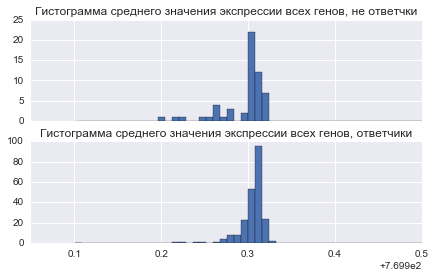

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
for row, resp in zip([0, 1], ["не ответчки", "ответчики"]):
    mrange=(770,770.4)
    vrange=(2984, 2990)
    _ = axes[row].hist(xpressions[responses==row, :].mean(axis=1), 
                         range=mrange, bins=50)
    _ = axes[row].set_title("Гистограмма среднего значения экспрессии всех генов, {}".format(resp))
    

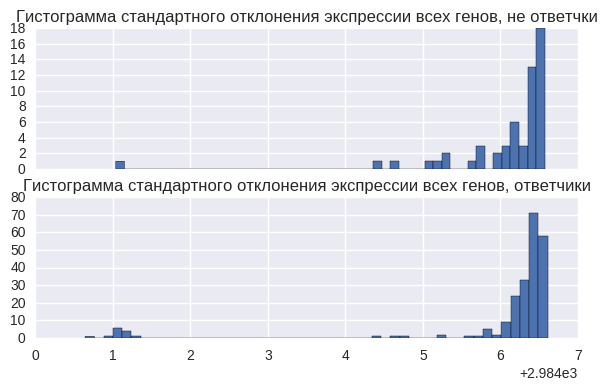

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
for row, resp in zip([0, 1], ["не ответчки", "ответчики"]):
    _ = axes[row].hist(xpressions[responses==row, :].var(axis=1)**.5, 
                          bins=50)
    _ = axes[row].set_title("Гистограмма стандартного отклонения экспрессии всех генов, {}".format(resp))

In [17]:
sc.stats.entropy()

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
from sklearn.manifold import TSNE, MDS, LocallyLinearEmbedding

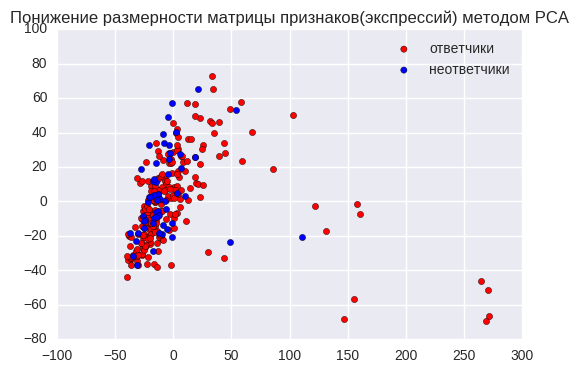

In [10]:
pca = PCA(n_components=2)
transformed = pca.fit_transform(scale(xpressions))
_ = plt.scatter(x=transformed[responses==1,0:1], y=transformed[responses==1,1:2], c='r', label="ответчики")
_ = plt.scatter(x=transformed[responses==0,0:1], y=transformed[responses==0,1:2], label="неответчики")
_ = plt.legend()
_ = plt.title("Понижение размерности матрицы признаков(экспрессий) методом PCA")

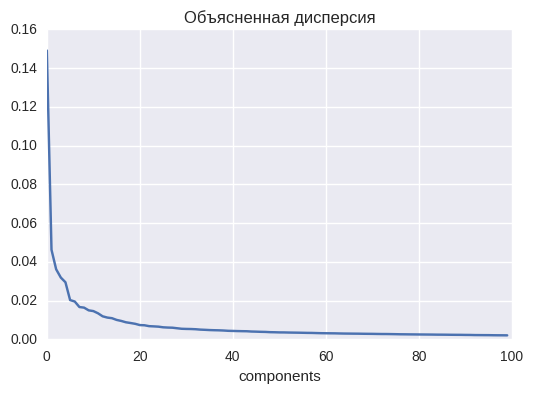

In [12]:
pca = PCA(n_components=100)
transformed = pca.fit_transform(scale(xpressions))
plt.plot(pca.explained_variance_ratio_)
plt.title("Объясненная дисперсия")
_ = plt.xlabel("components")


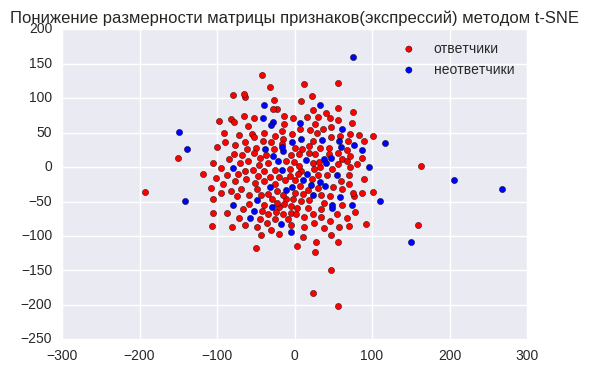

In [13]:
tsne = TSNE(n_components=2)
transformed = tsne.fit_transform(scale(xpressions))
_ = plt.scatter(x=transformed[responses==1,0:1], y=transformed[responses==1,1:2], c='r', label="ответчики")
_ = plt.scatter(x=transformed[responses==0,0:1], y=transformed[responses==0,1:2], label="неответчики")
_ = plt.legend()
_ = plt.title("Понижение размерности матрицы признаков(экспрессий) методом t-SNE")

In [212]:
pca = PCA(n_components=100)
transformed = pca.fit_transform(xpressions)

In [213]:
scores = []
for n in range(0, transformed.shape[1]):
    scores.append(cross_val_score(rf, transformed[:,:n+1], responses, cv=4))
    if n%10 == 0:
        print(n+1)        


1
51


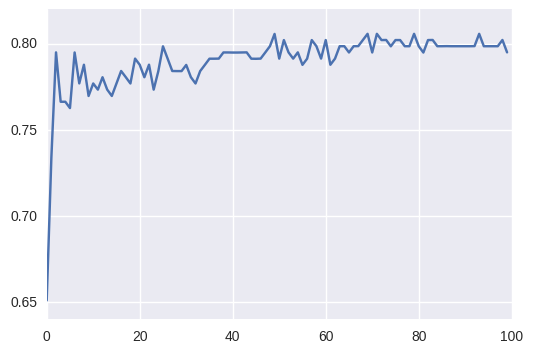

In [214]:
plt.plot(np.array(scores).mean(axis=1))

In [219]:
rf = RandomForestClassifier(n_estimators=500)
svc = svm.SVC(kernel="linear", C=1)
logregr = LogisticRegression(C=100)
rf_scores = []
svm_scores = []
logregr_scores = []
nb_it = 5
for it in range(nb_it):    
    print ("iteration: {}".format(it))
    rf_scores.append(cross_val_score(rf, xpressions, responses, cv=4))
    # svm_scores.append(cross_val_score(svc, scale(xpressions), responses, cv=4))
    # logregr_scores.append(cross_val_score(logregr, xpressions, responses, cv=4))

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4


In [220]:
print(np.mean(rf_scores), np.var(rf_scores)**.5)
# print(np.mean(logregr_scores), np.var(logregr_scores)**.5)
print(np.mean(svm_scores), np.var(np.array(rf_scores).reshape((-1)))**.5)

0.786345755694 0.0239585287074
nan 0.0239585287074


/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [41]:
# predicted = lg.predict(xpressions)
np.mean(responses), np.sum(responses == 1), np.sum(responses == 0)

(0.79856115107913672, 222, 56)

In [80]:
# print((predicted == responses).mean())
# lg.predict_log_proba(xpressions[5,:])

Эвристика: посмотри насколько хорошо выборка разделяется на ответчиков/неответчиков только подному гену, 
отберем те гены которые 
позволяют разделить выборку точнее чем если просто в каждом отдельно случае выбирать наибольший класс
(в таком случае точность классифиакции получается 0.799)

In [14]:
# Эвристика 1:
gen_res = []
for g in range(xpressions.shape[1]):
    lg = LogisticRegression(penalty='l1', C=1)
    lg.fit(xpressions[:, g:g+1], responses)
    gen_res.append((lg.predict(xpressions[:, g:g+1]) == responses).mean())

In [15]:
gen_res = np.array(gen_res)
good = np.arange(gens.shape[0])[gen_res > responses.mean()]

In [16]:
gen_res[good].max(), gen_res[good].min(), gen_res[good].shape

(0.8309352517985612, 0.80215827338129497, (713,))

Всего таких генов оказалось 709, максимальная точность классификации по одному гену (accuracy) $0.83$

In [28]:
print(gens[gen_res.argmax()], gens[gen_corr.argmax()])
print(gen_res.argmax() in intersection_gens, gen_corr.argmax() in intersection_gens)

COCH TTK
True True


Так же для каждого гена посчитаем корреляцию между уровнем экспрессии и значением класса ответчика (0, 1), и отберем те гены корелляция которых выше чем $95$ перцентиль


In [24]:
gen_corr = []
for g in range(xpressions.shape[1]):    
    gen_corr.append(abs(np.corrcoef(xpressions[:, g], responses)[0,1]))
gen_corr = np.array(gen_corr)    

In [25]:
good_coor = np.arange(gens.shape[0])[gen_corr > np.percentile(gen_corr, 95)]

In [26]:
intersection_gens = np.array([id for id in set(good_coor).intersection(set(good))], dtype=np.int)

Таких генов получилось $692$, из них $283$ пересекаются с генами отборанными по преддыдущей эвристике

In [336]:
# intersection_gens.shape, good_coor.shape
# gens[intersection_gens]


0.84158456486042699

In [23]:
rf = RandomForestClassifier(n_estimators=200)

svc = svm.SVC(kernel="linear", C=1)
logregr = LogisticRegression(C=100)
rf_scores = []
svm_scores = []
logregr_scores = []
nb_it = 2
for it in range(nb_it):    
    print ("iteration: {}".format(it))
    rf_scores.append(cross_val_score(rf, xpressions[:, intersection_gens], 
                                     responses, 
                                     cv=StratifiedKFold(n_splits=5, shuffle=True),
                                    scoring=scorer))
    svm_scores.append(cross_val_score(svc, scale(xpressions[:, intersection_gens]), responses, cv=4))
    logregr_scores.append(cross_val_score(logregr, scale(xpressions[:, intersection_gens]), responses, cv=4))
    

iteration: 0


NameError: name 'scorer' is not defined

In [251]:
print(np.mean(rf_scores), np.var(rf_scores)**.5)
print(np.mean(logregr_scores), np.var(logregr_scores)**.5)
print(np.mean(svm_scores), np.var(np.array(rf_scores).reshape((-1)))**.5)
rf_scores

0.836216678059 0.0310250632122
0.776811594203 0.0512463139101
0.827277432712 0.0310250632122


[array([ 0.87719298,  0.78571429,  0.85454545,  0.85454545,  0.8       ]),
 array([ 0.85964912,  0.82142857,  0.87272727,  0.83636364,  0.8       ])]

Среднее качество классификации (accuracy) $0.84$, стандартное отклонение качества $0.02$. Если классифицировать аналогичным способом но по всем генам, то качество получается $0.77$

In [51]:
resp_mask = responses == 1
nonresp_mask = responses == 0

gen_pdfs = []
nb_bins = 15
for g in range(xpressions.shape[1]):    
    hists = get_gen_hists(xpressions[:, g], [resp_mask, nonresp_mask], bins=nb_bins)    
    p = (hists[0] + 1) / (hists[0].sum() + hists[0].shape[0]) 
    q = (hists[1] + 1) / (hists[1].sum() + hists[1].shape[0])
    gen_pdfs.append((p, q))
#     gen_pdf_sims.append(get_pdf_sim(p, q))
    if g % 1000 == 0:
         print(g)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000


In [52]:
gen_pdf_sims = []
for gen_pdf in gen_pdfs:
    gen_pdf_sims.append(get_pdf_sim(gen_pdf[0], gen_pdf[1]))    
    #gen_pdf_sims.append(sc.stats.entropy(gen_pdf[0], gen_pdf[1]))    
gen_pdf_sims = np.array(gen_pdf_sims)

(21,)

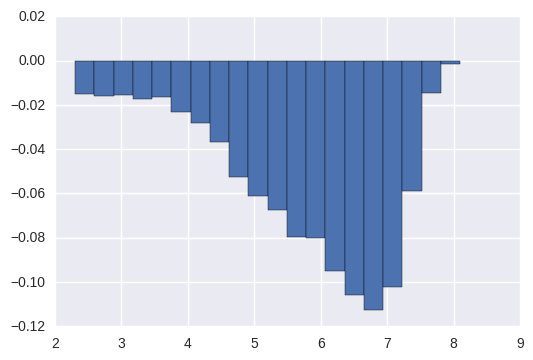

In [27]:
nb_bins = 20
hist, edges = np.histogram(gen_pdf_sims, bins=nb_bins)
plt.bar(edges[:-1], -hist/hist.sum(), width=(edges[-1]-edges[0])/(edges.shape[0]-1) )
edges.shape

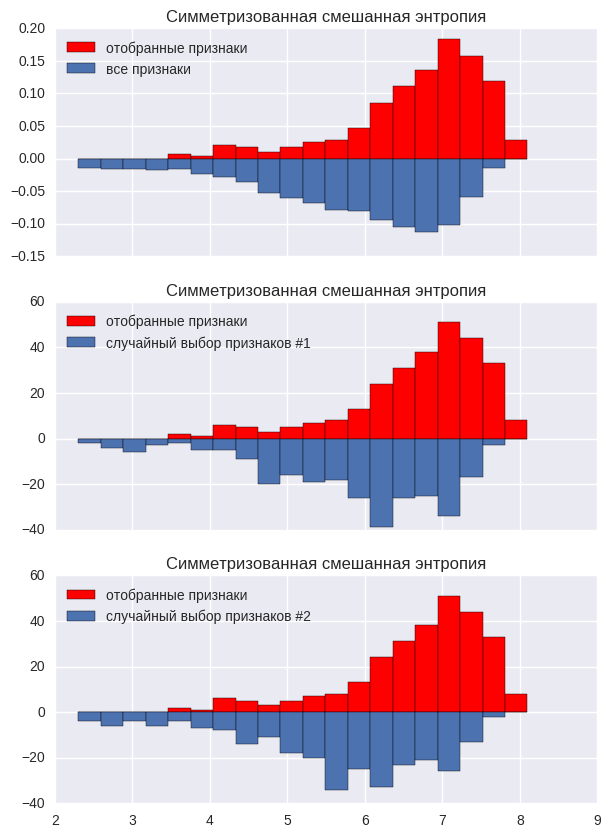

In [28]:

# plt.hist(np.array(gen_pdf_sims), bins=25)
# gen_pdf = np.arange(gens.shape[0])[gen_pdf_sims < np.percentile(gen_pdf_sims, 1)]
rest_gens = set(range(gens.shape[0]))
rest_gens = list(rest_gens.difference(intersection_gens))
np.random.choice(rest_gens, size=intersection_gens.shape[0])
all_hist, edges = np.histogram(gen_pdf_sims, bins=20)
intr_hist, _ = np.histogram(gen_pdf_sims[intersection_gens], bins=edges)
rnd_1_hist, _ = np.histogram(gen_pdf_sims[np.random.choice(rest_gens, size=intersection_gens.shape[0])],
                             bins=edges)
rnd_2_hist, _ = np.histogram(gen_pdf_sims[np.random.choice(rest_gens, size=intersection_gens.shape[0])],
                             bins=edges)
width = (edges[-1]-edges[0])/(edges.shape[0]-1)

fig, axes = plt.subplots(3, ncols=1, figsize=(7, 10), sharex=True)

_ = axes[0].bar(edges[:-1], intr_hist/intr_hist.sum(), width=width, color='r',
                     label="отобранные признаки")
_ = axes[0].bar(edges[:-1], -all_hist/all_hist.sum(), width=width,
                     label="все признаки")
_ = axes[0].set_title("Симметризованная смешанная энтропия")
_ = axes[0].legend(loc="best")


_ = axes[1].bar(edges[:-1], intr_hist, width=width, color='r',
                     label="отобранные признаки")
_ = axes[1].bar(edges[:-1], -rnd_1_hist, width=width,
                     label="случайный выбор признаков #1")
_ = axes[1].set_title("Симметризованная смешанная энтропия")
_ = axes[1].legend(loc="best")


_ = axes[2].bar(edges[:-1], intr_hist, width=width, color='r',
                     label="отобранные признаки")
_ = axes[2].bar(edges[:-1], -rnd_2_hist, width=width,
                     label="случайный выбор признаков #2")
_ = axes[2].set_title("Симметризованная смешанная энтропия")
_ = axes[2].legend(loc="best")
# fig, axes = plt.subplots(3, ncols=1, figsize=(7, 10), sharex=True)

# _ = axes[0].hist(gen_pdf_sims[intersection_gens], bins=25, color='r',
#                      normed=True, label="отобранные признаки")
# _ = axes[0].hist(gen_pdf_sims, bins=25, 
#                      normed=True, label="все признаки")
# _ = axes[0].set_title("Симметризованная смешанная энтропия")
# _ = axes[0].legend(loc="best")


# _ = axes[1].hist(gen_pdf_sims[intersection_gens], bins=25, color='r',                
#                  label="отобранные признаки")
# _ = axes[1].hist(gen_pdf_sims[np.random.choice(rest_gens, size=intersection_gens.shape[0])],
#                  bins=25, 
#                 label="случайный выбор признаков")
# _ = axes[1].set_title("Симметризованная смешанная энтропия")
# _ = axes[1].legend(loc="best")


# _ = axes[2].hist(gen_pdf_sims[intersection_gens], bins=25, color='r',
#                      label="отобранные признаки")
# _ = axes[2].hist(gen_pdf_sims[np.random.choice(rest_gens, size=intersection_gens.shape[0])],
#                  bins=25, 
#                  label="случайный выбор признаков")
# _ = axes[2].set_title("Симметризованная смешанная энтропия")
# _ = axes[2].legend(loc="best")


In [57]:
def get_n_biggest_sims_ids(sims, subset, n=140):
    subsims = sims[subset]
    bound = np.sort(subsims)[-n]    
    return subset[subsims >= bound][:n]
# np.sort(gen_pdf_sims[get_n_biggest_sims_ids(gen_pdf_sims, intersection_gens, 140)]), np.sort(gen_pdf_sims[intersection_gens])

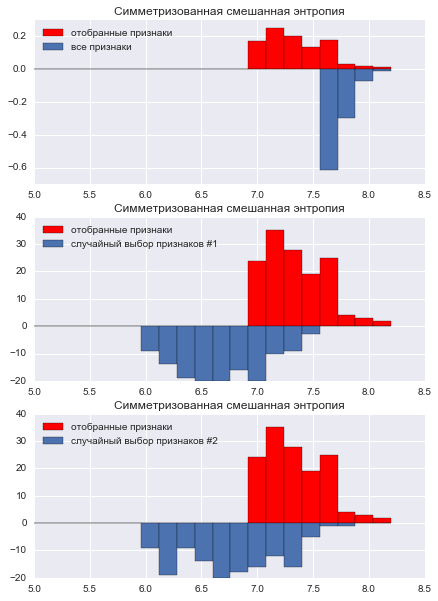

In [68]:
rest_gens = set(range(gens.shape[0]))
rest_gens = list(rest_gens.difference(intersection_gens))
np.random.choice(rest_gens, size=intersection_gens.shape[0])
N = 140
bins=20
all_gens = get_n_biggest_sims_ids(gen_pdf_sims, np.arange(gens.shape[0]), N)
all_hist, edges = np.histogram(gen_pdf_sims[all_gens], bins=bins, range=(5,8.2))
#all_hist, _ = np.histogram(gen_pdf_sims[all_gens], bins=edges)
intr_hist, _ = np.histogram(gen_pdf_sims[get_n_biggest_sims_ids(gen_pdf_sims,intersection_gens, N)],
                            bins=edges)

rnd_1_gens = get_n_biggest_sims_ids(gen_pdf_sims,                                    
                                    np.random.choice(rest_gens, size=intersection_gens.shape[0]),
                                    N)
rnd_2_gens = get_n_biggest_sims_ids(gen_pdf_sims,
                                    np.random.choice(rest_gens, size=intersection_gens.shape[0]),
                                    N)

rnd_1_hist, _ = np.histogram(gen_pdf_sims[rnd_1_gens],
                             bins=edges)
rnd_2_hist, _ = np.histogram(gen_pdf_sims[rnd_2_gens],
                             bins=edges)
width = (edges[-1]-edges[0])/(edges.shape[0]-1)

fig, axes = plt.subplots(3, ncols=1, figsize=(7, 10))#, sharex=True)


_ = axes[0].bar(edges[:-1], intr_hist/intr_hist.sum(), width=width, color='r',
                     label="отобранные признаки")
_ = axes[0].bar(edges[:-1], -all_hist/all_hist.sum(), width=width,
                     label="все признаки")
_ = axes[0].set_title("Симметризованная смешанная энтропия")
_ = axes[0].legend(loc="best")


_ = axes[1].bar(edges[:-1], intr_hist, width=width, color='r',
                     label="отобранные признаки")
_ = axes[1].bar(edges[:-1], -rnd_1_hist, width=width,
                     label="случайный выбор признаков #1")
_ = axes[1].set_title("Симметризованная смешанная энтропия")
_ = axes[1].legend(loc="best")


_ = axes[2].bar(edges[:-1], intr_hist, width=width, color='r',
                     label="отобранные признаки")
_ = axes[2].bar(edges[:-1], -rnd_2_hist, width=width,
                     label="случайный выбор признаков #2")
_ = axes[2].set_title("Симметризованная смешанная энтропия")
_ = axes[2].legend(loc="best")

In [69]:
best_31 = np.array(list(set(all_gens).intersection(set(get_n_biggest_sims_ids(gen_pdf_sims,intersection_gens, N)))),
                   dtype=np.int)
len(set(all_gens).intersection(set(get_n_biggest_sims_ids(gen_pdf_sims,intersection_gens, N))))

30

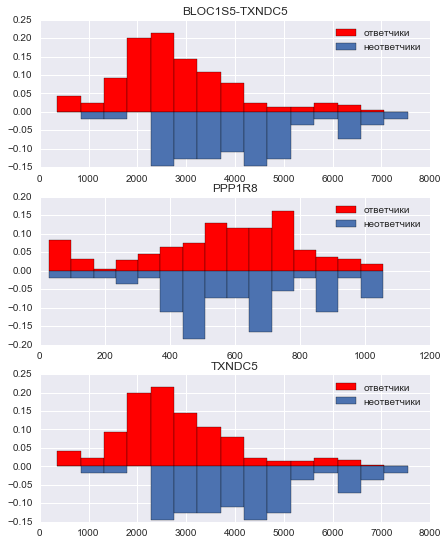

In [72]:
# Гены с максимальным абсолютным J
tgens = get_n_biggest_sims_ids(gen_pdf_sims, np.arange(gens.shape[0]), 3)
# tgens = get_n_biggest_sims_ids(-gen_pdf_sims, best_31, 3)
fig, axes = plt.subplots(tgens.shape[0], ncols=1, figsize=(7, 3*tgens.shape[0]))
nb_bins = 15
for i, g in enumerate(tgens):
    lower = np.percentile(xpressions[:, g] ,1.)
    upper = np.percentile(xpressions[:, g] ,98.5)    
    _, edges = np.histogram(xpressions[:, g], bins=nb_bins, range=(lower, upper))
    hist_0, _ = np.histogram(xpressions[responses==0, g], bins=edges)
    hist_1, _ = np.histogram(xpressions[responses==1, g], bins=edges)
    width = edges[1] - edges[0]
    # print(width)
    _ = axes[i].bar(edges[:-1], hist_1/hist_1.sum(), color='r', width=width,
                    label="ответчики")
    _ = axes[i].bar(edges[:-1], -hist_0/hist_0.sum(), width=width,
                    label="неответчики")
    _ = axes[i].set_title(gens[g])

    _ = axes[i].legend()

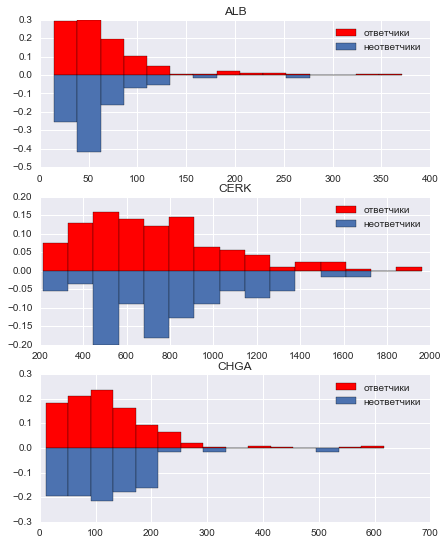

In [73]:
# Гены с минимальным абсолютным J
tgens = get_n_biggest_sims_ids(-gen_pdf_sims, np.arange(gens.shape[0]), 3)
fig, axes = plt.subplots(tgens.shape[0], ncols=1, figsize=(7, 3*tgens.shape[0]))
nb_bins = 15
for i, g in enumerate(tgens):
    lower = np.percentile(xpressions[:, g] ,1.)
    upper = np.percentile(xpressions[:, g] ,98.5)    
    _, edges = np.histogram(xpressions[:, g], bins=nb_bins, range=(lower, upper))
    hist_0, _ = np.histogram(xpressions[responses==0, g], bins=edges)
    hist_1, _ = np.histogram(xpressions[responses==1, g], bins=edges)
    width = edges[1] - edges[0]
    # print(width)
    _ = axes[i].bar(edges[:-1], hist_1/hist_1.sum(), color='r', width=width,
                    label="ответчики")
    _ = axes[i].bar(edges[:-1], -hist_0/hist_0.sum(), width=width,
                    label="неответчики")
    _ = axes[i].set_title(gens[g])

    _ = axes[i].legend()

In [48]:
rf = RandomForestClassifier(n_estimators=250)
good_pdf = np.arange(gens.shape[0])[(gen_pdf_sims < 6.6) * (gen_pdf_sims > 6.4)]
intesection_gens3 = np.array([id for id in set(good_pdf).intersection(set(intersection_gens))], dtype=np.int)
print(intesection_gens3.shape)
rf_scores = []
nb_it = 5
for it in range(nb_it):    
    print ("iteration: {}".format(it))
    rf_scores.append(cross_val_score(rf,
                                     xpressions[:, intesection_gens3],
                                     responses,
                                     cv=StratifiedKFold(n_splits=10, shuffle=True)))

(18,)
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4


In [49]:
#np.mean(rf_scores), len(set(intersection_gens).intersection(gen_pdf)), len(gen_pdf)
rf_scores, np.mean(np.array(rf_scores), axis=1)

([array([ 0.82758621,  0.89655172,  0.75      ,  0.64285714,  0.85714286,
          0.82142857,  0.85185185,  0.85185185,  0.88888889,  0.92592593]),
  array([ 0.79310345,  0.75862069,  0.75      ,  0.89285714,  0.82142857,
          0.85714286,  0.88888889,  0.81481481,  0.81481481,  0.85185185]),
  array([ 0.86206897,  0.82758621,  0.85714286,  0.82142857,  0.89285714,
          0.82142857,  0.77777778,  0.85185185,  0.88888889,  0.81481481]),
  array([ 0.82758621,  0.86206897,  0.78571429,  0.85714286,  0.89285714,
          0.89285714,  0.81481481,  0.85185185,  0.77777778,  0.81481481]),
  array([ 0.82758621,  0.79310345,  0.82142857,  0.85714286,  0.78571429,
          0.89285714,  0.81481481,  0.81481481,  0.85185185,  0.88888889])],
 array([ 0.8314085 ,  0.82435231,  0.84158456,  0.83774859,  0.83482029]))

Ниже представлены гистограммы по нескольким генам вошедшим в пересечение отобранных по эвристикам: для каждого гена
на одном графике отображены гистограмма значений экспрессии для ответчика и отдельно гистограмма для неответчика.

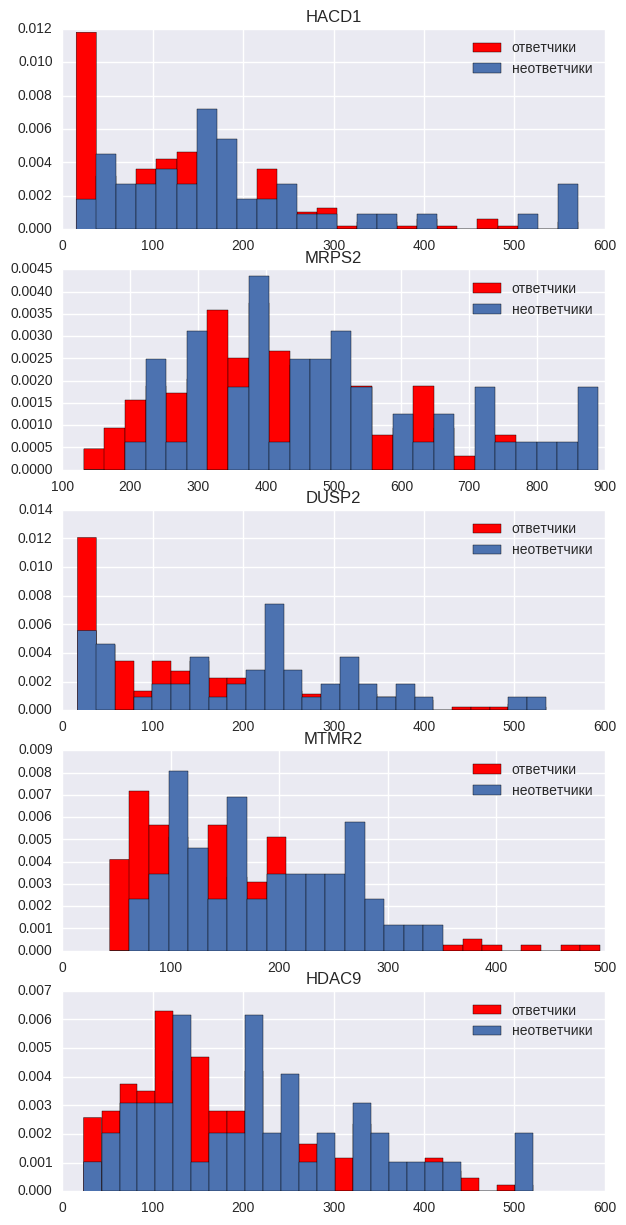

In [52]:
N = 5 #intersection_gens.shape[0]//20
fig, axes = plt.subplots(N, ncols=1, figsize=(7, 3*N))
for i, g in enumerate(intesection_gens3[:N]):
    lower = np.percentile(xpressions[:, g] ,2.5)
    upper = np.percentile(xpressions[:, g] ,97.5)
    _ = axes[i].hist(xpressions[responses==1, g], range=(lower, upper), bins=25, color='r',
                     normed=True, label="ответчики")
    _ = axes[i].hist(xpressions[responses==0, g], range=(lower, upper), bins=25, 
                     normed=True, label="неответчики")
    _ = axes[i].set_title(gens[g])
    _ = axes[i].legend()

In [632]:
rf = RandomForestClassifier(n_estimators=200)
svc = svm.SVC(kernel="linear", C=100)
clf =  rf
# logregr = LogisticRegression(C=100)
# features = np.arange(intersection_gens.shape[0] + 1)
features = intersection_gens[:]
rf_scores = []
cv_results = []
skfold = StratifiedKFold(n_splits=10, shuffle=True)
skfold.get_n_splits(xpressions, responses)
folds, cases = get_splits(responses)
# for train, test in skfold.split(xpressions, responses):    
#     c0test = test[responses[test] == 0]
#     c0train = test[responses[test] == 0]
#     splits.append(train[:22], test[:5])
#     # rest.append(train[])

for train, test in cases:        
    # print ((responses[test] == 0).sum())
    clf.fit(xpressions[np.array(train),: ][:,features], responses[train])
    prediction = clf.predict(xpressions[test,:][:, features])
    cv_results.append((responses[test], prediction))   
    

In [256]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import scale

def get_metrics(conf):
    prec_0 = conf[0,0]/(conf[1,0] + conf[0,0])
    if (conf[1,0] + conf[0,0]) == 0:
        prec_0 = 0
    recall_0 = conf[0,0]/(conf[0,0] + conf[0,1])
    prec_1 = conf[1,1]/(conf[1,1] + conf[0,1])
    recall_1 = conf[1,1]/(conf[1,1] + conf[1,0])
    if (conf[1,1] + conf[0,1]) == 0:
        prec_1 = 0
    # print(prec_0, recall_0, prec_1, recall_1)
    return prec_0, recall_0, prec_1, recall_1


def get_splits(responses, k=10):
    nonresp = np.arange(responses.shape[0])[responses==0]
    resp = np.arange(responses.shape[0])[responses==1]
    np.random.shuffle(nonresp)
    np.random.shuffle(resp)
    folds = []
    for i in range(9):
        folds.append(np.hstack((resp[i*22:i*22+22],nonresp[i*5:i*5+5])))
    folds.append(np.hstack((resp[9*22:],nonresp[9*5:])))
    cases = []
    for i in range(10):
        test = folds[i]
        train = np.hstack((fold for j, fold in enumerate(folds) if i != j))
        cases.append( (train, test) )                      
    return folds, cases


def do_simmetry_class_cv(X, y, clf, iters=10, cv=10):
    nonresp = np.arange(y.shape[0])[y==0]
    resp = np.arange(y.shape[0])[y==1]
    results_a = []
    results_b = []
    # print(nonresp)
    for it in range(iters):
        print("iteration: {}".format(it))
        np.random.shuffle(resp)
        np.random.shuffle(nonresp)
        indicies = np.hstack((nonresp, resp[:nonresp.shape[0]]))
        # print(indicies)
        stat, common_stat = do_cross_val(X[indicies, :], 
                     y[indicies],
                     clf, cv)
        results_a.append(stat.mean(axis=0))
        # print(stat.mean(axis=0))
        results_b.append(np.array(common_stat))    
    return np.vstack(results_a), np.vstack(results_b)


def do_cross_val(X, y, clf,  cv=10):
    skfold = StratifiedKFold(n_splits=cv, shuffle=True)    
    cv_results = []
    # print ((y==1).sum(), (y==0).sum())
    skfold.get_n_splits(X, y)    
    for train, test in skfold.split(X, y):        
        clf.fit(X[train, :], y[train])
        prediction = clf.predict(X[test, :])
        cv_results.append((y[test], prediction))
        # print(y[test].shape, (y[test] == 0).sum())        
    conf_m =  confusion_matrix(cv_results[0][0], cv_results[1][0]) * 0
    stat = []    
    for actual, predicted in cv_results:
        conf =  confusion_matrix(actual, predicted)
        stat.append(np.array(get_metrics(conf)))
        conf_m = conf_m + conf
    # print((conf_m[0, 0] + conf_m[1, 1])/conf_m.sum())    
    return np.vstack(stat), get_metrics(conf_m)

In [55]:
symmetr_res_a, symmetr_res_b = do_simmetry_class_cv(order_features
                                                     responses, rf, iters=10)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9


In [307]:
# symmetr_res_a.mean(axis=0), symmetr_res_b.mean(axis=0)
scaled_xpr  = scale(xpressions)
print(scaled_xpr.mean(axis=0)[1], xpressions.mean(axis=0)[1])

-6.62938928373e-17 2145.36807554


In [338]:
rf = RandomForestClassifier(n_estimators=200)
svc = svm.SVC(kernel="linear", C=100)


# full_svc_smtr_a, full_svc_smtr_b = do_simmetry_class_cv(scaled_xpr,
#                                                      responses, svc, iters=10)

# intr_svc_smtr_a, intr_svc_smtr_b = do_simmetry_class_cv(scaled_xpr[:, intersection_gens],
#                                                     responses, svc, iters=10)

# full_rf_smtr_a, full_rf_smtr_b = do_simmetry_class_cv(xpressions,
#                                                      responses, rf, iters=10)

# intr_rf_smtr_a, intr_rf_smtr_b = do_simmetry_class_cv(xpressions[:, intersection_gens],
#                                                      responses, rf, iters=10)

# best31_rf_smtr_a, best31_rf_smtr_b = do_simmetry_class_cv(xpressions[:, best_31],

#                                                      responses, rf, iters=10)
best31_svc_smtr_a, best31_svc_smtr_b = do_simmetry_class_cv(order_features3, responses, svc, iters=10)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9


In [339]:
# print(intr_rf_smtr_a.mean(axis=0), intr_rf_smtr_b.mean(axis=0))
# print()
# print(full_rf_smtr_a.mean(axis=0), full_rf_smtr_b.mean(axis=0))
# print()
# print(best31_rf_smtr_a.mean(axis=0), best31_rf_smtr_b.mean(axis=0))
# print()
# print()
# print(intr_svc_smtr_a.mean(axis=0), intr_svc_smtr_b.mean(axis=0))
# print()
# print(full_svc_smtr_a.mean(axis=0), full_svc_smtr_b.mean(axis=0))
# print()
print(best31_svc_smtr_a.mean(axis=0), best31_svc_smtr_b.mean(axis=0))
# prec_0, recall_0, prec_1, recall_1

[ 0.97        0.43066667  0.65222042  1.        ] [ 1.          0.42857143  0.63646116  1.        ]


In [340]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import scale

def get_metrics(conf):
    prec_0 = conf[0,0]/(conf[1,0] + conf[0,0])
    if (conf[1,0] + conf[0,0]) == 0:
        prec_0 = 0
    recall_0 = conf[0,0]/(conf[0,0] + conf[0,1])
    prec_1 = conf[1,1]/(conf[1,1] + conf[0,1])
    recall_1 = conf[1,1]/(conf[1,1] + conf[1,0])
    if (conf[1,1] + conf[0,1]) == 0:
        prec_1 = 0
    accuracy = (conf[0,0] + conf[1, 1]) / (conf.sum())
    # print(prec_0, recall_0, prec_1, recall_1)
    return prec_0, recall_0, prec_1, recall_1, accuracy


def get_splits(responses, k=10):
    nonresp = np.arange(responses.shape[0])[responses==0]
    resp = np.arange(responses.shape[0])[responses==1]
    np.random.shuffle(nonresp)
    np.random.shuffle(resp)
    folds = []
    for i in range(9):
        folds.append(np.hstack((resp[i*22:i*22+22],nonresp[i*5:i*5+5])))
    folds.append(np.hstack((resp[9*22:],nonresp[9*5:])))
    cases = []
    for i in range(10):
        test = folds[i]
        train = np.hstack((fold for j, fold in enumerate(folds) if i != j))
        cases.append( (train, test) )                      
    return folds, cases


def do_simmetry_class_cv(X, y, clf, iters=10, cv=10):
    nonresp = np.arange(y.shape[0])[y==0]
    resp = np.arange(y.shape[0])[y==1]
    results_a = []
    results_b = []
    # print(nonresp)
    for it in range(iters):
        print("iteration: {}".format(it))
        np.random.shuffle(resp)
        np.random.shuffle(nonresp)
        indicies = np.hstack((nonresp, resp[:nonresp.shape[0]]))
        # print(indicies)
        stat, common_stat = do_cross_val(X[indicies, :], 
                     y[indicies],
                     clf, cv)
        results_a.append(stat.mean(axis=0))
        # print(stat.mean(axis=0))
        results_b.append(np.array(common_stat))    
    return np.vstack(results_a), np.vstack(results_b)


def do_cross_val(X, y, clf,  cv=10):
    skfold = StratifiedKFold(n_splits=cv, shuffle=True)    
    cv_results = []
    # print ((y==1).sum(), (y==0).sum())
    skfold.get_n_splits(X, y)    
    for train, test in skfold.split(X, y):        
        clf.fit(X[train, :], y[train])
        prediction = clf.predict(X[test, :])
        cv_results.append((y[test], prediction))
        # print(y[test].shape, (y[test] == 0).sum())        
    conf_m =  confusion_matrix(cv_results[0][0], cv_results[1][0]) * 0
    stat = []    
    for actual, predicted in cv_results:
        conf =  confusion_matrix(actual, predicted)
        stat.append(np.array(get_metrics(conf)))
        conf_m = conf_m + conf
    # print((conf_m[0, 0] + conf_m[1, 1])/conf_m.sum())    
    return np.vstack(stat), get_metrics(conf_m)

In [288]:
2*0.8*0.775 / (0.8+ 0.775), 2*0.831*0.754 / (0.831+ 0.754), 2*0.8 /(1.81)

(0.7873015873015874, 0.7906296529968454, 0.8839779005524863)

In [433]:
def get_splits(responses, k=10):
    nonresp = np.arange(responses.shape[0])[responses==0]
    resp = np.arange(responses.shape[0])[responses==1]
    np.random.shuffle(nonresp)
    np.random.shuffle(resp)
    folds = []
    for i in range(9):
        folds.append(np.hstack((resp[i*22:i*22+22],nonresp[i*5:i*5+5])))
    folds.append(np.hstack((resp[9*22:],nonresp[9*5:])))
    cases = []
    for i in range(10):
        test = folds[i]
        train = np.hstack((fold for j, fold in enumerate(folds) if i != j))
        cases.append( (train, test) )                      
    return folds, cases
    

In [434]:
folds, cases = get_splits(responses)

In [435]:
for case in cases:
    print( (responses[case[0]] == 0).sum(), (responses[case[0]] == 1).sum() )
    print( (responses[case[1]] == 0).sum(), (responses[case[1]] == 1).sum() )
    print()

51 200
5 22

51 200
5 22

51 200
5 22

51 200
5 22

51 200
5 22

51 200
5 22

51 200
5 22

51 200
5 22

51 200
5 22

45 198
11 24



In [347]:
intr_svc_smtr_a, intr_svc_smtr_b = do_simmetry_class_cv(order_features2,
                                                      responses, svc, iters=10)
order_features.shape, order_features2.shape, order_features3.shape

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9


((278, 26), (278, 70), (278, 9))

In [348]:
print(intr_svc_smtr_a.mean(axis=0), intr_svc_smtr_b.mean(axis=0))
print()
# print(best31_svc_smtr_a.mean(axis=0), best31_svc_smtr_b.mean(axis=0))
# prec_0, recall_0, prec_1, recall_1

[ 1.          0.739       0.81063889  1.          0.8695    ] [ 1.          0.7375      0.79232805  1.          0.86875   ]



In [ ]:
print(intr_svc_smtr_a.mean(axis=0), intr_svc_smtr_b.mean(axis=0))
print()